In [1]:
import tensorflow as tf
from tensorflow import keras

import os
from os import path

import tempfile
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cbv7s65a because the default path (/home/juliuswa/installed/apache-tomcat-9.0.30/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df_name = "95"

data_path = "../../RoboDocData"
df_path = f"{data_path}/{df_name}"

df = pd.read_pickle(f"{df_path}/dataframe_{df_name}.pkl")

In [3]:
with open(f"{data_path}/disease_matrix_raw.npy", 'rb') as f:
    disease_matrix_raw = np.load(f)

with open(f"{data_path}/symptoms_dict.npy", 'rb') as f:
    symptoms_dict = np.load(f)

with open(f"{data_path}/patient_history_dict.npy", 'rb') as f:
    patient_history_dict = np.load(f)

with open(f"{data_path}/diagnoses_dict.npy", 'rb') as f:
    diagnoses_dict = np.load(f) 

In [4]:
df.describe()

,age,gender,weight,height,heartrate_mean,heartrate_min,heartrate_max,meanbp_mean,meanbp_min,meanbp_max,...,1430,1431,1432,1433,1434,1435,1436,1437,length_of_stay_hospital,days_to_death
count,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,...,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,4.927600e+04,49276.000000,21266.000000
mean,3.785158e-17,2.667635e-18,-2.447736e-17,-8.201177e-19,4.217748e-18,-2.703685e-17,4.866632e-18,1.292361e-17,-5.767861e-18,5.302827e-17,...,-6.092303e-18,-7.966857e-18,9.805363e-18,-1.103103e-17,6.660076e-18,-8.651791e-18,7.678464e-18,-4.181699e-18,10.001152,516.919261
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,...,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,10.824429,750.269258
min,-2.851985e+00,-1.132784e+00,-3.679919e+00,-7.150134e+00,-3.551337e+00,-4.715110e+00,-3.556091e+00,-5.410569e+00,-4.293148e+00,-3.161874e+00,...,-1.044598e+01,-1.423567e+01,-1.254131e+01,-1.166184e+01,-8.771547e+00,-1.245394e+01,-1.092345e+01,-1.362189e+01,0.000000,0.000000
25%,-6.602848e-01,-1.132784e+00,-6.305664e-01,-1.308840e-17,-7.229681e-01,-6.636825e-01,-6.937438e-01,-7.131228e-01,-5.493726e-01,-5.718688e-01,...,-2.307914e-01,-2.201078e-01,-1.900663e-01,-1.945371e-01,-2.193400e-01,-1.964945e-01,-2.140415e-01,-2.077441e-01,4.040000,18.000000
50%,8.950739e-02,8.827810e-01,8.096634e-17,-1.308840e-17,-8.015685e-02,-6.248149e-02,-1.115714e-01,-9.270538e-02,1.349679e-16,-1.853008e-01,...,-2.542474e-02,-2.151379e-02,4.834280e-03,2.598291e-03,-9.215172e-03,2.073447e-04,-1.437202e-02,-1.388533e-02,6.920000,149.000000
75%,7.816233e-01,8.827810e-01,3.858846e-01,-1.308840e-17,6.269355e-01,6.055197e-01,6.161441e-01,5.277120e-01,5.517378e-01,3.172375e-01,...,1.692542e-01,1.802531e-01,1.904886e-01,1.836319e-01,1.849409e-01,2.104166e-01,1.817449e-01,1.797262e-01,11.950000,722.750000
max,1.531416e+00,8.827810e-01,1.013457e+01,3.581620e+01,5.062333e+00,4.680327e+00,8.572500e+00,6.731886e+00,4.882772e+00,7.507402e+00,...,1.253282e+01,1.584002e+01,1.445355e+01,1.794241e+01,1.372316e+01,1.258050e+01,1.579031e+01,1.538091e+01,294.660000,4166.000000


In [25]:
from sklearn.cluster import KMeans, DBSCAN, spectral_clustering

cluster_cnt = 8

t_start = time.time()

clustering = KMeans(n_clusters=cluster_cnt).fit(np.array([df[0], df[1], df[2], df[3], df[4], df[5], df[6], df[7], df[8]]).T)
t_end = time.time()

cluster_labels = clustering.labels_

print(f"Time elapsed: {(t_end - t_start) / 60:.2f} minutes")
print(cluster_labels[:20])


Time elapsed: 0.07 minutes
[4 1 5 7 5 4 4 3 6 1 7 3 1 6 5 2 0 6 3 3]


In [26]:
df["cluster"] = cluster_labels

In [27]:
df.head()

,age,gender,weight,height,heartrate_mean,heartrate_min,heartrate_max,meanbp_mean,meanbp_min,meanbp_max,...,1432,1433,1434,1435,1436,1437,length_of_stay_hospital,days_to_death,died_in_hospital,cluster
0,-0.314227,0.882781,0.709301,5.792595e-01,-1.494342,-1.465284,-1.130373,0.793605,-0.182336,1.786196,...,0.338638,-1.311366,0.688960,0.077232,-0.073634,-0.029856,10.61,95.0,0,4
1,0.435565,0.882781,0.478289,5.792595e-01,-0.465844,-0.262882,-0.790772,-0.181336,0.478330,-0.339928,...,0.036300,0.125635,0.122869,0.135796,0.025071,0.117645,6.33,NaN,0,1
2,0.608594,-1.132784,-0.815376,-1.125754e+00,0.112687,0.338319,-0.499686,-0.092705,-0.035521,-0.223958,...,0.040327,0.605153,-0.597103,0.314791,-0.406310,0.927886,15.08,23.0,0,5
3,-0.487256,-1.132784,-0.122341,-7.847512e-01,1.141184,1.273521,0.373572,-0.801754,-0.108928,-0.378585,...,-0.013563,0.425975,-0.051111,-0.408861,0.038872,0.121768,2.73,2.0,1,7
4,0.839300,0.882781,1.725752,-1.308840e-17,-1.237217,-1.264884,-1.178887,-1.333540,-1.430261,-1.035750,...,0.570992,-1.950549,0.177128,1.541920,-1.497021,0.692167,2.79,489.0,0,5


<IPython.core.display.Javascript object>


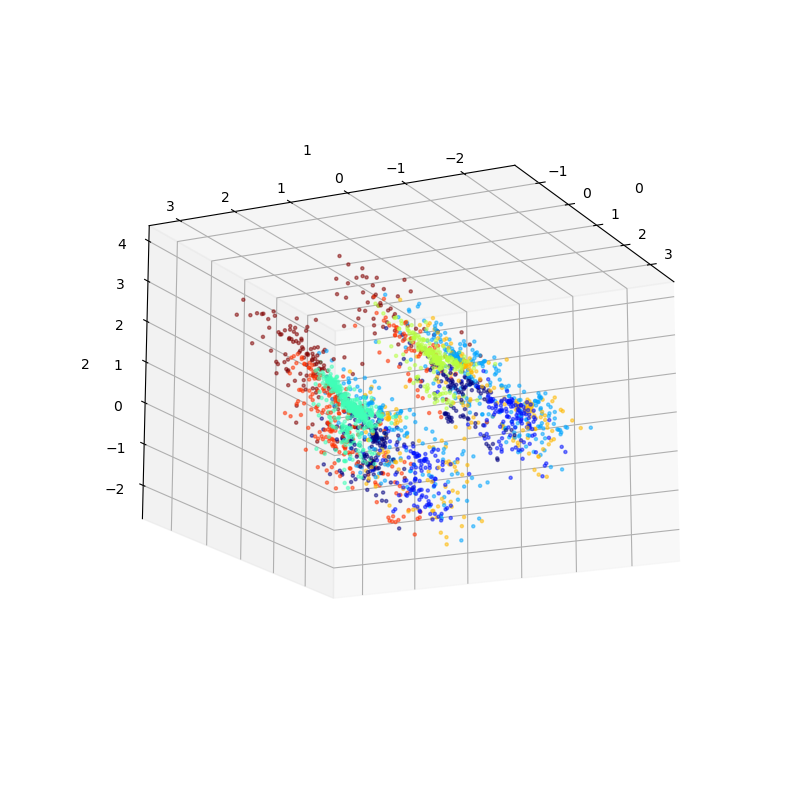

In [28]:
import matplotlib.cm as cm
%matplotlib notebook

rd_df = df[::20]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel("0")
ax.set_ylabel("1")
ax.set_zlabel("2")

ax.scatter(rd_df[0], rd_df[1], rd_df[2], alpha=0.5, c=rd_df.cluster, marker=".", cmap=cm.jet)


plt.show()

In [29]:
def index_to_name(i: int):
    lenS = len(symptoms_dict)
    lenPH = len(patient_history_dict)
    lenD = len(diagnoses_dict)

    if i < lenS:
        return f"Symptom: {symptoms_dict[i][1]}"
    elif (i > lenS) & (i < lenS + lenPH):
        return f"History: {patient_history_dict[i - lenS][1]}"
    elif i > lenS + lenPH:
        return f"Disease: {diagnoses_dict[i - (lenS + lenPH)][1]}"
    else:
        return "Invalid index"

def index_to_description(i: int):
    lenS = len(symptoms_dict)
    lenPH = len(patient_history_dict)
    lenD = len(diagnoses_dict)

    if i < lenS:
        return f"{symptoms_dict[i][2]}"
    elif (i > lenS) & (i < lenS + lenPH):
        return f"{patient_history_dict[i - lenS][2]}"
    elif i > lenS + lenPH:
        return f"{diagnoses_dict[i - (lenS + lenPH)][2]}"
    else:
        return "Invalid index"

def print_disease_frequency(disease_matrix, n):
    diseases_count = np.sum(disease_matrix, axis=0)
    index_sorted = np.argsort(diseases_count)[::-1]

    for i in range(0, n):
        print(f"#{i+1:03}: {index_to_name(index_sorted[i])}, {int(diseases_count[index_sorted[i]])} times")
        
def print_disease_frequency_ext(disease_matrix, n):
    diseases_count = np.sum(disease_matrix, axis=0)
    index_sorted = np.argsort(diseases_count)[::-1]

    for i in range(0, n):
        print(f"#{i+1:03}: {index_to_name(index_sorted[i])}, {int(diseases_count[index_sorted[i]])} times")
        print(f"\t{index_to_description(index_sorted[i])}")

def print_group_difference(g1_diseases, g2_diseases, g1_label, g2_label, n, lower_bound):
    g1_diseases_count = np.sum(g1_diseases, axis=0)
    g2_diseases_count = np.sum(g2_diseases, axis=0)

    g1_typicalness = np.zeros_like(g1_diseases_count)
    for d in range(len(g1_diseases_count)):
        if g1_diseases_count[d] + g2_diseases_count[d] > lower_bound:
            g1_typicalness[d] = g1_diseases_count[d] / max(g1_diseases_count[d] + g2_diseases_count[d], 1)

    index_sorted = np.argsort(g1_typicalness)[::-1]

    for i in range(0, n):
        print(f"#{i+1:03}: {index_to_name(index_sorted[i])}")
        print(f"\t{index_to_description(index_sorted[i])}")
        print(f"\t{int(g1_diseases_count[index_sorted[i]])} in {g1_label}, {int(g2_diseases_count[index_sorted[i]])} in {g2_label}")
        print(f"\t=> {g1_typicalness[index_sorted[i]]:.2f} of people in {g1_label}")

In [30]:
for i in range(cluster_cnt):
    print(f"\nGROUP {i}:\n")
    group_diseases = disease_matrix_raw[df.cluster == i]
    not_group_diseases = disease_matrix_raw[df.cluster != i]
    print_group_difference(group_diseases, not_group_diseases, f"G{i}", f"not G{i}", 5, 100)


GROUP 0:

#001: Disease: Atrial fibrillation
	Atrial fibrillation
	4999 in G0, 7634 in not G0
	=> 0.40 of people in G0
#002: History: Long-term use anticoagul
	Long-term (current) use of anticoagulants
	1260 in G0, 2478 in not G0
	=> 0.34 of people in G0
#003: Disease: Atrial flutter
	Atrial flutter
	392 in G0, 802 in not G0
	=> 0.33 of people in G0
#004: Disease: Mitr/aortic mult involv
	Multiple involvement of mitral and aortic valves
	33 in G0, 78 in not G0
	=> 0.30 of people in G0
#005: History: Heart valve transplant
	Heart valve replaced by transplant
	134 in G0, 323 in not G0
	=> 0.29 of people in G0

GROUP 1:

#001: Disease: "AMI anterolateral
	 init"
	71 in G1, 69 in not G1
	=> 0.51 of people in G1
#002: Disease: "AMI anterior wall
	 init"
	264 in G1, 266 in not G1
	=> 0.50 of people in G1
#003: Disease: "AMI inferopost
	 initial"
	64 in G1, 72 in not G1
	=> 0.47 of people in G1
#004: Disease: Intermed coronary synd
	Intermediate coronary syndrome
	752 in G1, 876 in not G1
	=